In [8]:
#limpio la memoria
rm(list=ls())
gc()

#cargo librerias
library("data.table")
library("ROCR")
library("rpart")
library("rpart.plot")
library("caret")

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,618211,33.1,1083215,57.9,1083215,57.9
Vcells,1167787,9.0,65217887,497.6,81516407,622.0


Loading required package: lattice

Warning message:
“package ‘lattice’ was built under R version 3.6.3”
Loading required package: ggplot2



In [9]:

#Parametros entrada

#kcarpeta_datasets    <- "../input/laboratorio-de-implementacion-i-2021/"   #KAGGLE
kcarpeta_datasets    <- "~/buckets/b1/datasets/"                          #VM o Ubuntu

#Archivo con datos etiquetados para entrenamiento
karchivo_entrada      <-  paste0(kcarpeta_datasets, "paquete_premium_202011.csv")

#Archivo con datos sin etiquetar para generar la predicción
karchivo_predecir      <-  paste0(kcarpeta_datasets, "paquete_premium_202101.csv")

#Formato para submit en Kaggle
#karchivo_score      <-  "../input/uamds2020ldi1f1/Sample_201910_Fase_I.txt"

#Separador de campos en archivos
kcampos_separador     <-  "\t"

#Campo que identifica las muestras
kcampo_id             <-  "numero_de_cliente"

#Campo que contiene la clase a estimar
kclase_nomcampo       <-  "clase_ternaria"

#Valor de interés
kclase_valor_positivo <-  "BAJA+2"

#Campos a borrar para el entrenamiento
kcampos_a_borrar      <-  c(kcampo_id,kclase_nomcampo,"foto_mes")

#Campo que contendrá a la variable objetivo generada
kobjetivo             <-  "clase"

#Identificación del modelo
kmodelo               <-  "02-RPART"

#Ganancia por TP
kTPGain               <-  48750

#Pérdida por FP
kFPGain               <-  -1250

kSeed <- 0


#Establezco semilla aleatoria
set.seed(kSeed)


In [10]:
#cargo los datos
dataset <- fread(karchivo_entrada)

#Para hacer pruebas rapidas puedo reducir el dataset a una fraccion
#subsample <- sample(1:nrow(dataset), .1 * nrow(dataset))
#dataset <- dataset[subsample,]

In [11]:
#Genero la clase
dataset[,(kobjetivo) := as.integer(dataset[,..kclase_nomcampo] == kclase_valor_positivo)]

#Limpio campos a borrar
dataset[ ,  (kcampos_a_borrar) := NULL    ] 

#Completo missings
dataset[is.na(dataset)] <- 0

Warning message in `[.data.table`(dataset, , ..kclase_nomcampo):
“Both 'kclase_nomcampo' and '..kclase_nomcampo' exist in calling scope. Please remove the '..kclase_nomcampo' variable in calling scope for clarity.”


In [12]:
# generacion del modelo
formula  <-  formula(paste(kobjetivo, "~ ."))

In [13]:
train_rows <- createDataPartition(dataset$clase, p = .66, list = FALSE)

#train_rows <- sample(1:nrow(dataset), .66 * nrow(dataset))
train <- dataset[train_rows,]
test <- dataset[-train_rows,]

In [22]:
#Genero el modelo
t0       <-  Sys.time()
modelo   <-  rpart(formula,   data = train,   cp=0.001,   xval=0)
t1       <-  Sys.time()

tcorrida <-  as.numeric( t1 - t0, units = "secs")
print( tcorrida)

[1] 9.836196


In [23]:
#Evalúo sobre test
predicted <- predict(modelo, test,) # predicted values

In [24]:
#Detalles del modelo
modelo

n= 157482 

node), split, n, deviance, yval
      * denotes terminal node

     1) root 157482 612.5983000 0.0039052080  
       2) ctrx_quarter>=25.5 140969 222.6472000 0.0015819080  
         4) ctrx_quarter>=49.5 122243 108.9028000 0.0008916666 *
         5) ctrx_quarter< 49.5 18726 113.3060000 0.0060877920  
          10) mcaja_ahorro>=3597.4 11855  38.8717000 0.0032897510 *
          11) mcaja_ahorro< 3597.4 6871  74.1813400 0.0109154400  
            22) Visa_mconsumospesos< 214909.5 6864  72.2236300 0.0106352000  
              44) ctarjeta_visa_transacciones>=1.5 4849  29.8143900 0.0061868430 *
              45) ctarjeta_visa_transacciones< 1.5 2015  42.0823800 0.0213399500  
                90) chomebanking_transacciones< 41.5 1796  27.5634700 0.0155902000 *
                91) chomebanking_transacciones>=41.5 219  13.9726000 0.0684931500  
                 182) ctarjeta_debito_transacciones< 4.5 210  11.3142900 0.0571428600  
                   364) cliente_edad>=32.5 180   5

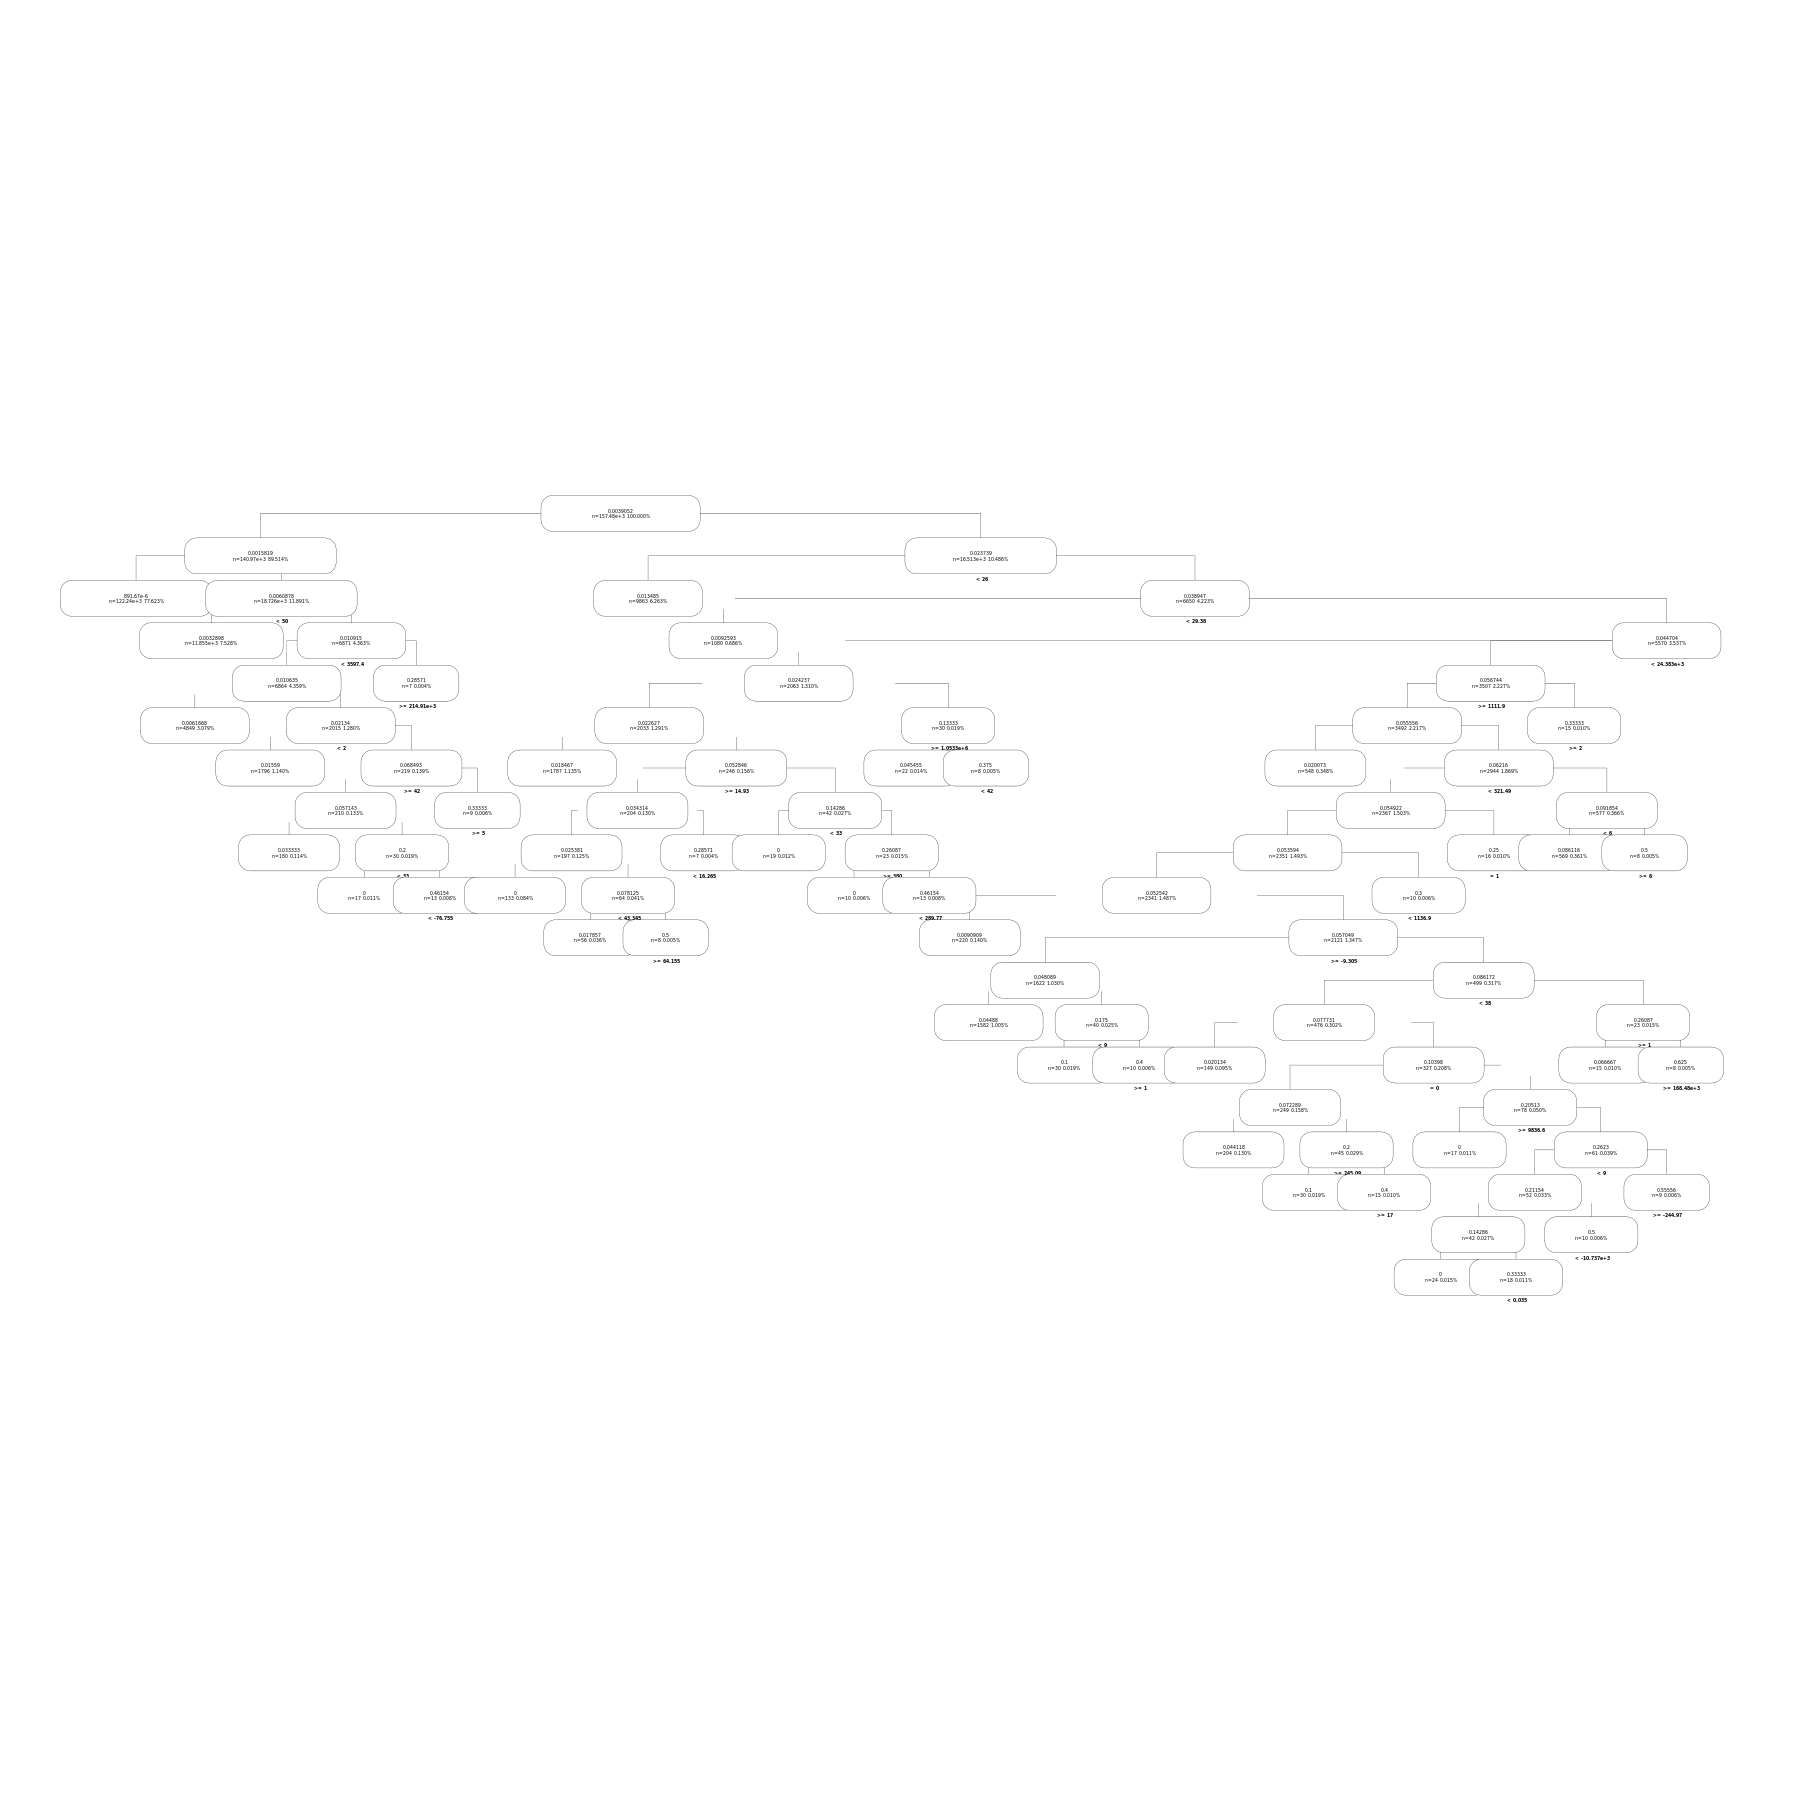

In [25]:
#Arbol generado
options(repr.plot.width=15, repr.plot.height=15)
prp(modelo, extra=101, digits=5, branch=1, type=4, varlen=0, faclen=0, tweak=1.3)

In [28]:
#Calculo ganancia sobre dataset de pruebas
test$score <- predicted
test$Predicted <- test$score > 0.025

#Selecciono primeros N
#seleccionar = 1400
#top_n = order(-test$score)[1:seleccionar]
#test[top_n,"Predicted"] <- 1

#calculo la ganancia de incentivar cada caso
test[  , ganancia:= kFPGain ] #-1250
test[ clase==1,   ganancia:= kTPGain] #48750


#Determino ganancia
print(paste("La Ganancia es:", 3*sum(test$Predicted*test$ganancia)))

[1] "La Ganancia es: 7676250"


[1] 17.46701


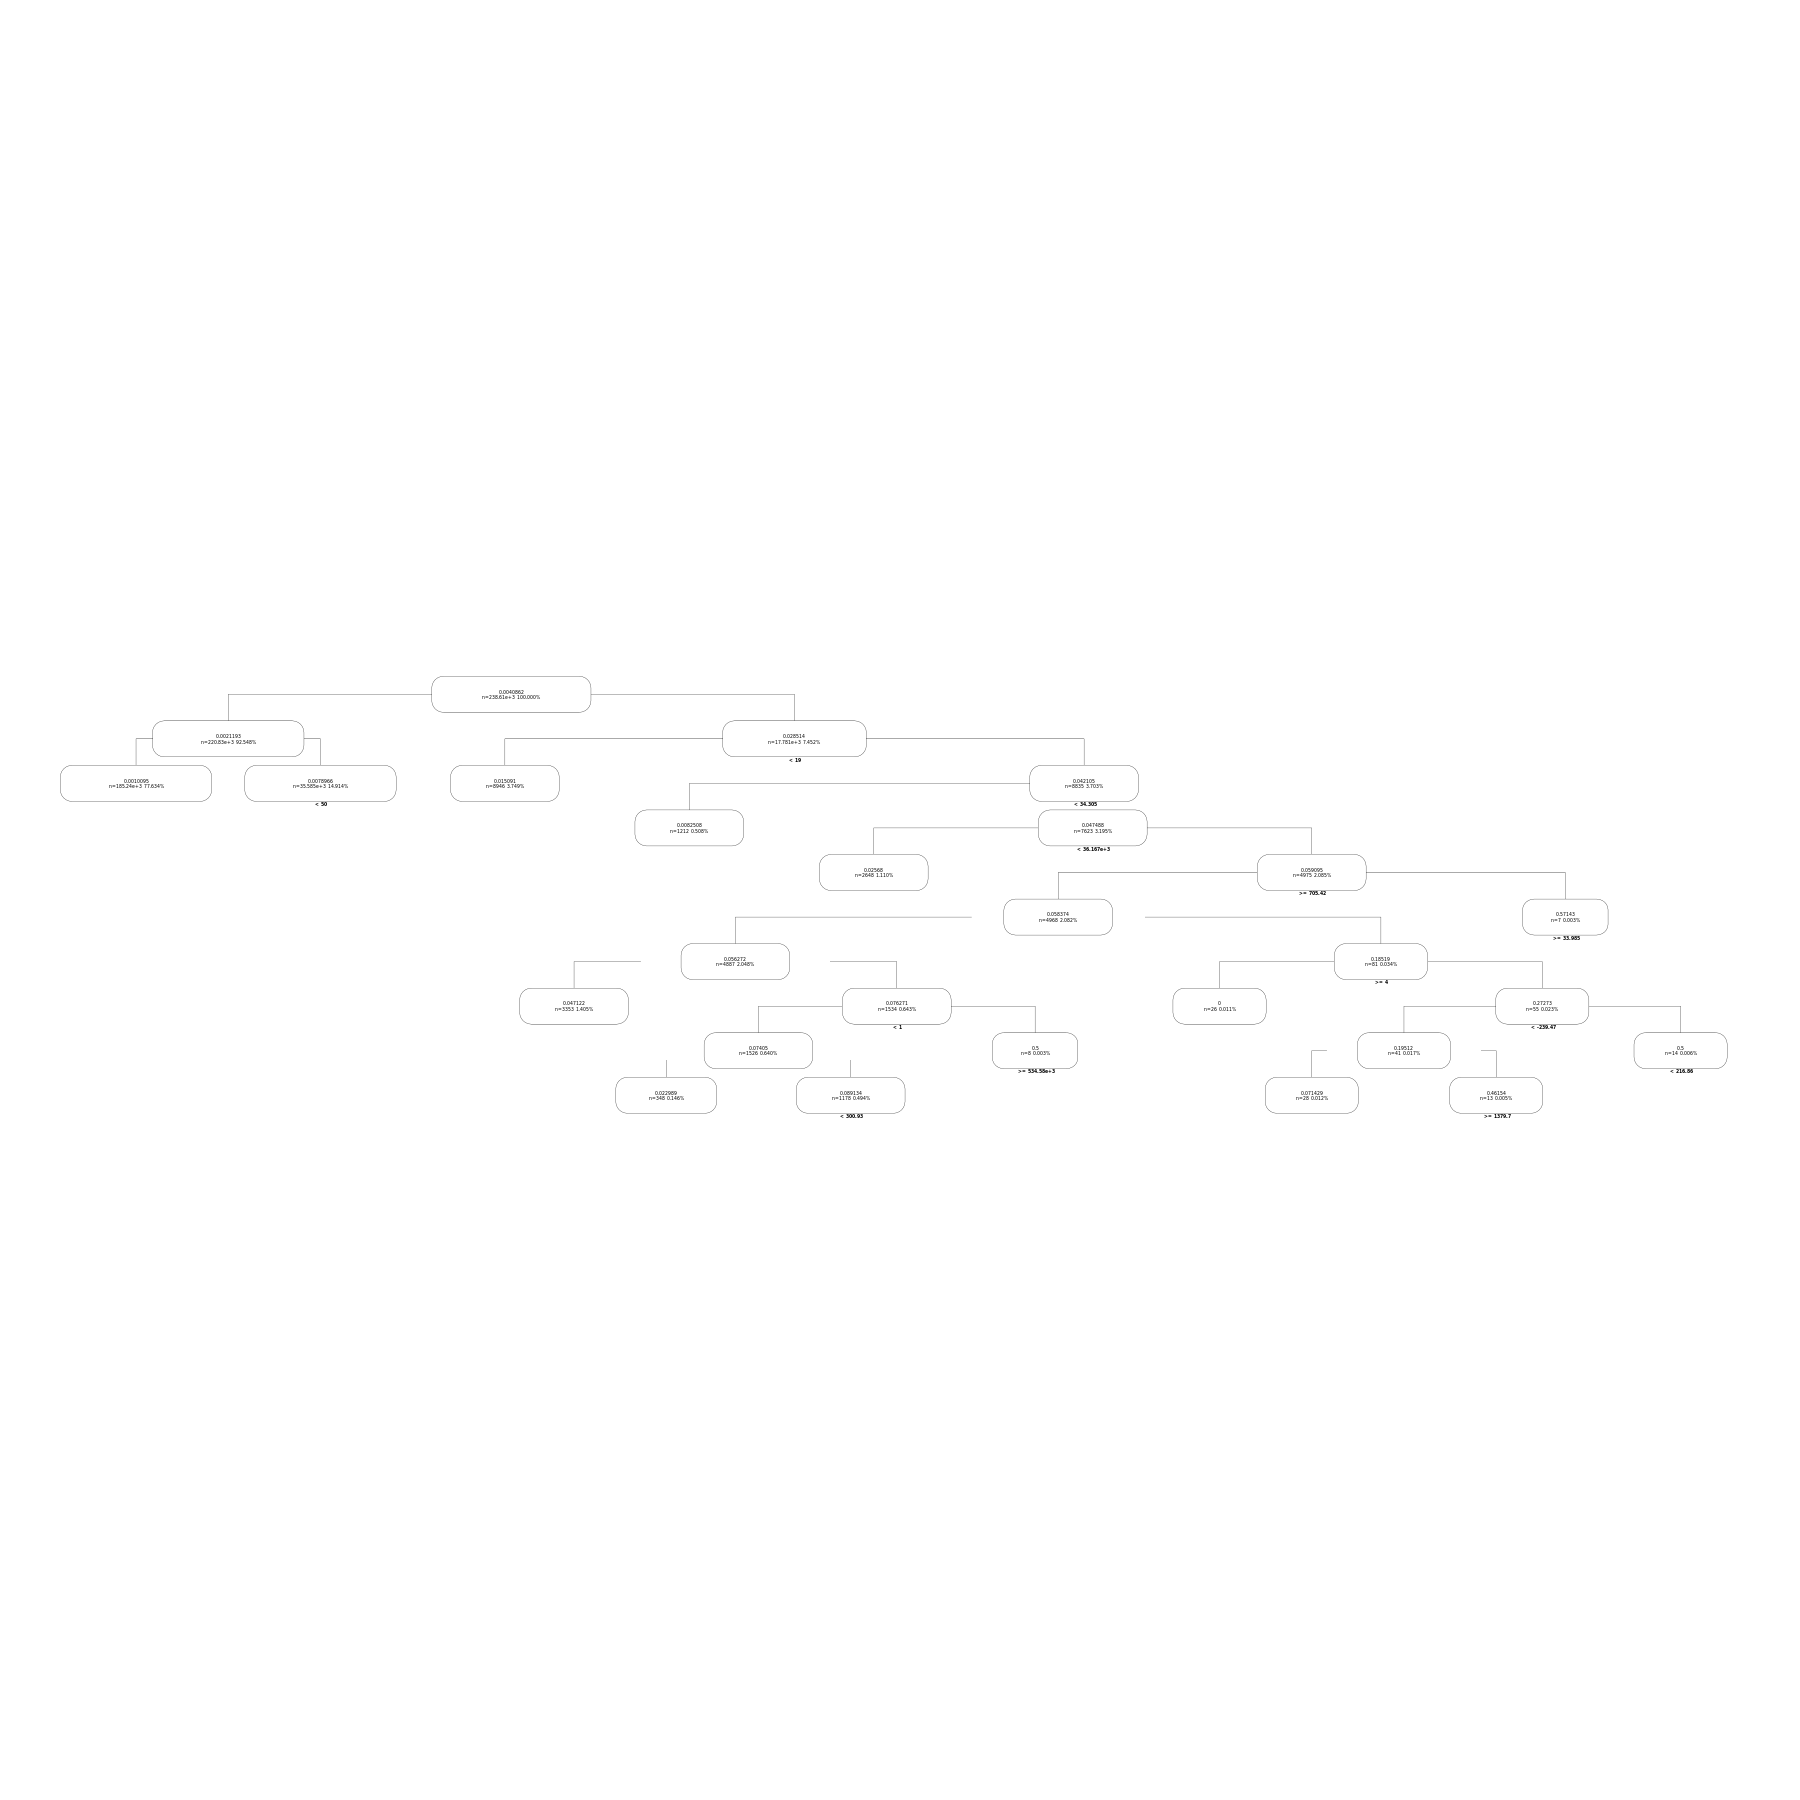

In [31]:
#Genero el modelo sobre dataset completo

t0       <-  Sys.time()
modelo   <-  rpart(formula,   data = dataset,  cp=        0.001,    xval=0)
t1       <-  Sys.time()

tcorrida <-  as.numeric( t1 - t0, units = "secs")
print( tcorrida)

#Arbol generado
options(repr.plot.width=15, repr.plot.height=15)
prp(modelo, extra=101, digits=5, branch=1, type=4, varlen=0, faclen=0, tweak=1.3)

In [32]:
#Leo datos a estimar
dataset_pred <- fread(karchivo_predecir)


#Genero la clase
#dataset_pred[,(kobjetivo) := as.integer(dataset[,..kclase_nomcampo] == kclase_valor_positivo)]

#Limpio campos a borrar
#dataset_pred[ ,  (kcampos_a_borrar) := NULL    ] 

prediccion  <- predict( modelo, dataset_pred ) #aplico el modelo

In [33]:
dataset_pred[ , prob_baja := prediccion]
dataset_pred[ , Predicted  := as.numeric(prob_baja > 0.025) ]

entrega  <- dataset_pred[   , list(numero_de_cliente, Predicted) ] #genero la salida

#genero el archivo para Kaggle
fwrite( entrega, file="./salida_rpart.csv", sep="," )